In [1]:
import numpy as np
from dynesty import NestedSampler
      
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

In [2]:
# generate dummy data
N = 50; mu = 5; sigma = 2
data = np.random.normal(mu, sigma, N)

In [3]:
def log_likelihood(params):
    mu, sigma = params
    return np.sum(np.log( (1/np.sqrt(2*np.pi*(sigma**2))) * (np.exp(-(data-mu)**2/(2*sigma**2))) ))

In [4]:
def prior_transform(u):
    # u ~ uniform [0,1]
    priors = np.array(u)

    # mu: 1 to 10
    priors[0] = 9*u[0] + 1

    # sigma: 1 to 5
    priors[1] = 4*u[1] + 1

    return priors

In [5]:
ndim = 2
# sampler = NestedSampler(log_likelihood, prior_transform, ndim)
sampler = NestedSampler(log_likelihood, prior_transform, ndim, nlive = 1000)


In [6]:
sampler.run_nested()

4802it [00:03, 1340.32it/s, +1000 | bound: 2 | nc: 1 | ncall: 38601 | eff(%): 15.430 | loglstar:   -inf < -104.527 <    inf | logz: -109.093 +/-  0.061 | dlogz:  0.001 >  1.009]


In [7]:
results = sampler.results
results.summary()

Summary
nlive: 1000
niter: 4802
ncall: 37601
eff(%): 15.430
logz: -109.093 +/-  0.153


In [8]:
results.samples[:,0].mean(), results.samples[:,1].mean()

(5.263828973635853, 2.531349617647186)

In [9]:
# get the posteriors
samples = results.samples
print(samples.shape) # (10886, 2)

weights = results.importance_weights()
print(weights.shape)

(5802, 2)
(5802,)


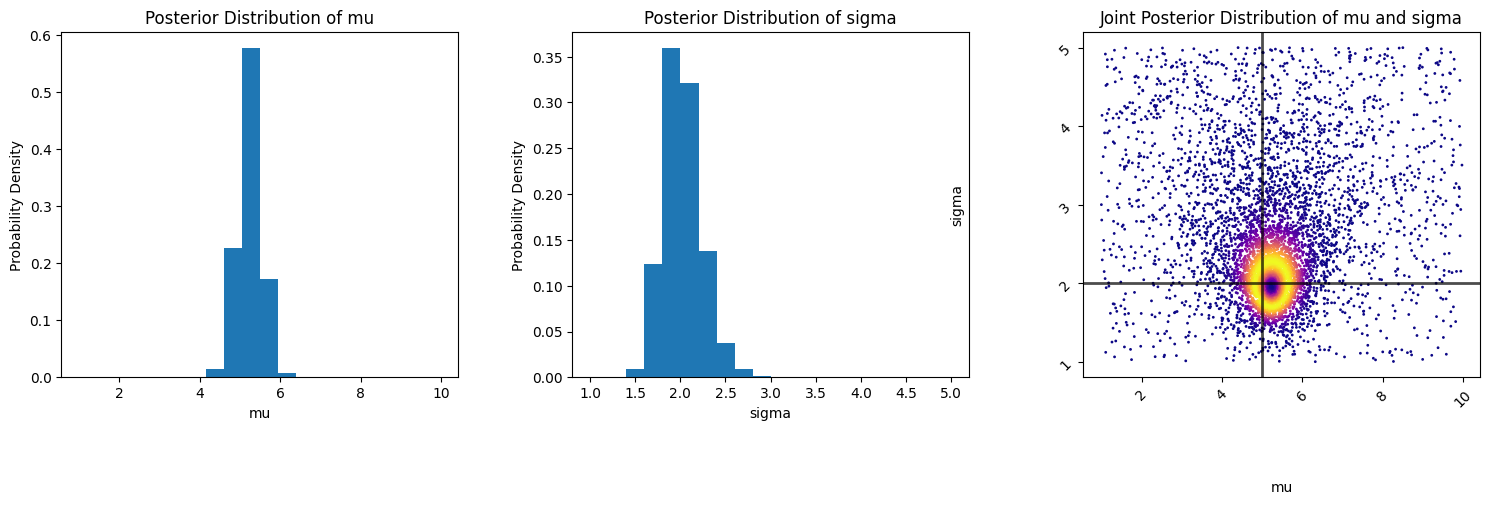

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot mu distribution
axes[0].hist(samples[:, 0], weights=weights, bins=20) # Use plt.hist here
axes[0].set_xlabel('mu')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Posterior Distribution of mu')

# Plot sigma distribution
axes[1].hist(samples[:, 1], weights=weights, bins=20) # Use plt.hist here
axes[1].set_xlabel('sigma')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Posterior Distribution of sigma')

# Plot joint distribution of mu and sigma
dyplot.cornerpoints(results, kde=True, fig=(fig, axes[2]), truths=[mu, sigma], truth_color='black')
axes[2].set_xlabel('mu')
axes[2].set_ylabel('sigma')
axes[2].set_title('Joint Posterior Distribution of mu and sigma')

plt.tight_layout()
plt.show()

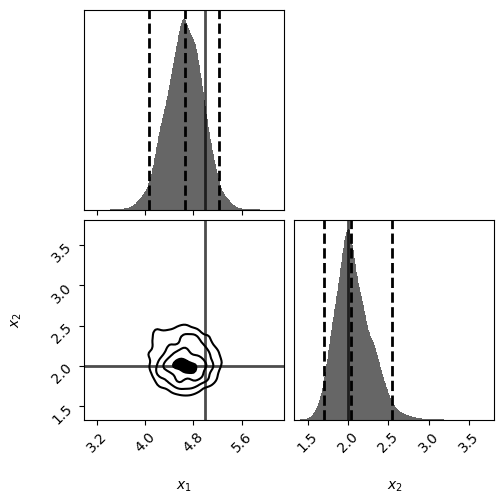

In [11]:
# Plot corner plot
fig, axes = dyplot.cornerplot(results, truths=[mu, sigma], truth_color='black')
plt.show()

# Py Variational Bayesian Monte Carlo - VBMC

In [23]:
from pyvbmc import VBMC
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# generate dummy data
N = 100; mu = 5; sigma = 2
data = np.random.normal(mu, sigma, N)

In [25]:
def log_likelihood(params):
    mu, sigma = params
    loglike = np.sum(np.log( (1/np.sqrt(2*np.pi*(sigma**2))) * (np.exp(-(data-mu)**2/(2*sigma**2 + 1e-5))) ))
    print('loglikelihod : ', mu, sigma, loglike)
    return loglike

In [26]:
mu_prior_distr = stats.uniform(3,7-3)
sigma_prior_distr = stats.uniform(1, 4-1);

def log_prior(params):
    mu, sigma = params
    log_prior_mu = mu_prior_distr.logpdf(mu)
    log_prior_sigma = sigma_prior_distr.logpdf(sigma)
    return log_prior_mu + log_prior_sigma

In [27]:
def log_joint(params):
    return log_likelihood(params) + log_prior(params)

In [28]:
# Bounds
lower_bound_mu_sigma = np.array([1, 1])
upper_bound_mu_sigma = np.array([10, 4])

# inverse CDF: min = point below with there is 0.1% data, max = point below which there is 99.9% data
plausible_low_mu, plausible_upp_mu = mu_prior_distr.ppf([0.001, 0.999])
plausible_low_sigma, plausible_upp_sigma = sigma_prior_distr.ppf([0.001, 0.999])

# plausible: high conc of posterior prob
plausible_lower_bound = np.array([plausible_low_mu, plausible_low_sigma])
plausible_upper_bound = np.array([plausible_upp_mu, plausible_upp_sigma])

In [29]:
# starting point
mu_0 = mu_prior_distr.rvs(1)[0]
sigma_0 = sigma_prior_distr.rvs(1)[0]

starting_pt = np.array([mu_0, sigma_0])
print(starting_pt)

[3.91278657 1.47325874]


In [30]:
lower_bound_mu_sigma,plausible_lower_bound, plausible_upper_bound, upper_bound_mu_sigma

(array([1, 1]), array([2.004, 1.003]), array([5.996, 3.997]), array([10,  4]))

In [31]:
vbmc = VBMC(log_joint, starting_pt, lower_bound_mu_sigma, upper_bound_mu_sigma, plausible_lower_bound, plausible_upper_bound)
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting lower bounds to floating point.
Casting upper bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
loglikelihod :  3.9127865655852774 1.4732587426276793 -232.2610125832108
loglikelihod :  4.823101726368631 3.881311771625063 -237.9498197554746
loglikelihod :  5.494250876777636 1.7453747913295978 -201.3099061090096
loglikelihod :  2.4842634337669285 1.1387214441676121 -480.43266845389985
loglikelihod :  2.8554530936908598 2.4237500690531073 -248.1961022005128
loglikelihod :  2.869719953875682 1.0173450493709644 -475.24154945221545
loglikelihod :  2.0086657039049474 3.7486718346622867 -268.22132701930764
loglikelihod :  4.526685435363765 3.9275601698193454 -2

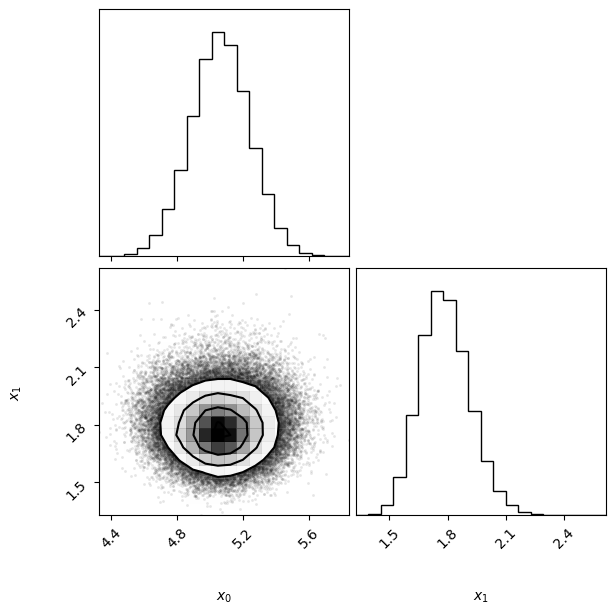

In [32]:
vp.plot();

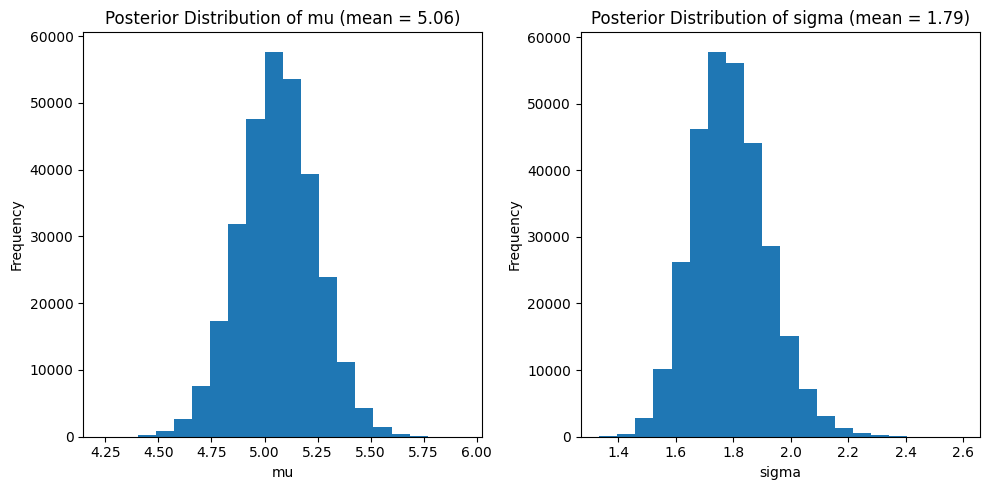

In [33]:
mu_and_sigma, _ = vp.sample(int(3e5))
mu_post = mu_and_sigma[:,0]
sigma_post = mu_and_sigma[:,1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mu_post, bins=20)
plt.title(f'Posterior Distribution of mu (mean = {np.mean(mu_post):.2f})')
plt.xlabel('mu')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sigma_post, bins=20)
plt.title(f'Posterior Distribution of sigma (mean = {np.mean(sigma_post):.2f})')
plt.xlabel('sigma')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Possible issue:

When the interval is too large, the vp.optimize stops in middle telling return value should be finite. It is actually triggered at `np.isnan(y_orig)` in [active_sample.py](https://raw.githubusercontent.com/acerbilab/pyvbmc/main/pyvbmc/vbmc/active_sample.py). This is probably due to line: `y_orig = optim_state["cache"]["y_orig"][idx]`. 

So, optim_state there is some issue. It might be due to np.exp of a very large negative number at this line.

```python
# Evaluate GP input length scale (use geometric mean)
            D = gp.D
            ln_ell = np.zeros((D, Ns_gp))
            for s in range(Ns_gp):
                ln_ell[:, s] = gp.posteriors[s].hyp[:D]
            optim_state["gp_length_scale"] = np.exp(ln_ell.mean(1)) # ???????????????????????????????????

            # Rescale GP training inputs by GP length scale
            gp.temporary_data["X_rescaled"] = (
                gp.X / optim_state["gp_length_scale"]
            )
```


# Bayesian Adaptive Direct Search - PyBADS

BADS is used as for optimization problems, unlike dynesty and VBMC which are used for Posterior estimation(u give likelihood and priors, they give posterior). So a bayesian relevant usecase of BADS can be to find parameter $\psi$ such that approximate likelihood function $q_{\psi}(data)$ is maximum.

In other words:
1. Problem: Likelihood functions are difficult to calculate analytically. But u need them to find posteriors.
2. So, you approximate likelihood with function like $q_{\psi}$ (may be sum of gaussians or a binomial distribtuion). 
3. Now, finding likelihood problem is reduced to problem of finding $\psi$ to maximize $q(data/\psi)$ (our approximate likelihood)
4. The above problem can be treated as optimization problem(find $\psi$ so that maximize loglikelihood). here BADS can be used.(Other than BADS, u can also try MNLE, where u train neural network to find $\psi$)
5. Once you have likelihood function, now you can use MCMC, VBMC, nested sampling to get posteriors.


In [41]:
from pybads import BADS

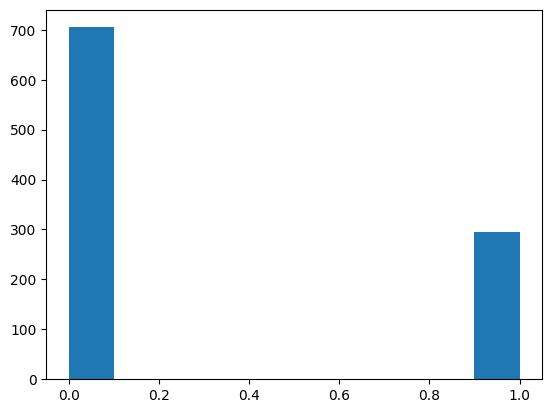

In [52]:
# Dummy data, find p
n = 1000
p = 0.3
data = np.random.binomial(1, p, n)
plt.hist(data);

In [53]:
def target_func(param):
    return -np.sum(data * np.log(param) + (1 - data) * np.log(1 - param)) 
    # likelihood maximized = negative loglikihood to be minimized


In [54]:
lower_bounds = np.array([0])
upper_bounds = np.array([1])
plausible_lower_bounds = np.array([0.01])
plausible_upper_bounds = np.array([0.99])
x0 = np.array([0.9]); 

In [55]:
bads = BADS(target_func, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds)
optimize_result = bads.optimize()

Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         1654.67               1                                 Uncertainty test
     0           4         622.414               1         Initial mesh            Initial points


     0           5         622.414             0.5         Refine grid             Train
     1          10         622.414            0.25         Refine grid             Train
     2          12          612.92            0.25     Successful search (ES-wcm)        
     2          13         608.007            0.25     Successful search (ES-wcm)        
     2          14         606.962            0.25     Successful search (ES-wcm)        
     2          15         606.797            0.25     Successful search (ES-wcm)        
     2          16         606.568            0.25     Successful search (ES-ell)        
     2          17         606.568            0.25     Incremental search (ES-ell)        
     2          21         606.568           0.125         Refine grid             
     3          26         606.568          0.0625         Refine grid             
     4          31         606.568         0.03125         Refine grid             Train
     5          36      

In [60]:
x_min = optimize_result['x']

print(x_min[0], p)

0.29504577636718754 0.3
